In [16]:
## Initial setup
import qiskit
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler
import os
from dotenv import load_dotenv
import json
import random
import matplotlib.pyplot as plt
import numpy as np

load_dotenv()
API_TOKEN = os.getenv("API_TOKEN")
service = QiskitRuntimeService(channel="ibm_quantum", token=API_TOKEN)
backend = service.backend(name="ibm_rensselaer")

In [2]:
''' 
trials schema:
{
"(num_vars,complexity)" : [
            {
                "job_id": string,
                "counts": counts | None,
                "input_state": binary_string, # format x0 x1 x2 ... xn 0
                "statement": string,
                "variables": [string, ...],
                "expected_result": boolean, # just the result qubit; implicitly expect first n qubits to be identical to input
            }
        ] 
}
'''

def unpack_key(key):
    return tuple(map(int, key[1:-1].split(",")))

class Trial:
    def __init__(self, num_vars, complexity, job_id, input_state, statement, variables, expected_result, counts=None):
        self.num_vars = num_vars
        self.compexity = complexity
        self.job_id = job_id
        self.input_state = input_state
        self.statement = statement
        self.variables = variables
        self.expected_result = expected_result
        self.counts = counts

    def as_dict(self):
        return {
            "job_id": self.job_id,
            "input_state": self.input_state,
            "statement": self.statement,
            "variables": self.variables,
            "expected_result": self.expected_result,
            "counts": self.counts
        }
    
    @classmethod
    def from_dict(cls, d, key):
        num_vars, complexity = unpack_key(key)
        return cls(
            num_vars = num_vars,
            complexity = complexity,
            job_id = d["job_id"],
            input_state = d["input_state"],
            statement = d["statement"],
            variables = d["variables"],
            expected_result = d["expected_result"],
            counts = d["counts"]
        )
    
    def get_key(self):
        return f"({self.num_vars},{self.compexity})"
    
    def set_counts(self, counts, trials = None):
        """ 
        call this once the job has finished running

        this updates the trials entry trials is provided and the entry exists
        """
        self.counts = counts
        if trials is not None:
            key = self.get_key()
            for trial in trials[key]:
                if trial["job_id"] == self.job_id:
                    trial["counts"] = counts

    def get_counts(self):
        """
        returns the counts for this job (waiting for them if they are not complete)
        this sets the counts if they are not already set
        """
        if self.counts is None:
            retrieved_job = service.job(self.job_id)
            counts = retrieved_job.result()[0].data.meas.get_counts()
            self.set_counts(counts)
        return self.counts
    
    def add_to_trials(self, trials):
        key = self.get_key()
        if key not in trials:
            trials[key] = []
        trials[key].append(self.as_dict())
        save_trials(trials)

    def total_expected_results(self):
        """ 
        Returns the expected binary string to be measured after the circuit is run
        Note that due to little-endian encoding of the counts, the first bit is the result bit
        and the input bits are in reverse order
        """
        result_bit = "1" if self.expected_result else "0"
        return result_bit + self.input_state[::-1]

def load_trials():
    trials = {}
    with open("benchmark_trials.json") as f:
        trials = json.load(f)
    return trials

def save_trials(trials):
    with open("benchmark_trials.json", "w") as f:
        json.dump(trials, f)

def init_trials(trials):
    from benchmark_functions import benchmark_functions
    for key in benchmark_functions.keys():
        trials[key] = trials.get(key, [])
    save_trials(trials)


In [3]:

NUM_TRIALS = 4
from benchmark_functions import *

def run_benchmark():
    trials = load_trials()
    init_trials(trials)
    for key in benchmark_functions.keys():
        num_vars, complexity = unpack_key(key)
        while len(trials[key]) < NUM_TRIALS:
            statement = benchmark_functions[key]["statement"]
            variables = benchmark_functions[key]["variables"]

            qc = qiskit.QuantumCircuit(num_vars + 1)  # +1 for result qubit

            # generate random input for each trial
            inpt = [random.randint(0, 1) for _ in range(num_vars)]
            for i, bit in enumerate(inpt):
                if bit:
                    qc.x(qc.qubits[i])

            qc.compose(eval(benchmark_functions[key]["classical_function"]).synth(registerless=False), inplace=True)
            qc.measure_all()
            qc_transpiled = qiskit.transpile(qc, backend=backend)
            sampler = Sampler(backend)
            job = sampler.run([qc_transpiled], shots=1024)

            
            expected_result = eval(benchmark_functions[key]["python_function"])(*inpt)
            
            Trial(num_vars, complexity, job.job_id(), ''.join(map(str, inpt)), statement, variables, expected_result).add_to_trials(trials)

def fetch_results():
    """ 
    Pulls the result counts from the jobs for all trials
    """
    trials = load_trials()
    for key in trials.keys():
        for _trial in trials[key]:
            trial = Trial.from_dict(_trial, key)
            counts = trial.get_counts()
            trial.set_counts(counts, trials)
    save_trials(trials)


In [7]:
run_benchmark()


In [10]:
fetch_results()

In [36]:
# example code to retrieve results from the first trial of 5 variables 9 complexity
trials = load_trials()
trial = Trial.from_dict(trials["(5,9)"][3], "(5,9)")
print("Experimental results:", trial.get_counts())
print("Expected:", trial.total_expected_results())
print("Number of matches:", trial.get_counts().get(trial.total_expected_results(), 0))
print("Shot count:", sum(trial.get_counts().values()))

from function_generator import get_python_function
print("Function used:", end="")
print(get_python_function(trial.statement, trial.variables))

Experimental results: {'111111': 968, '111110': 7, '110111': 13, '011111': 13, '111101': 4, '111011': 7, '101111': 4, '001111': 8}
Expected: 111111
Number of matches: 968
Shot count: 1024
Function used:
def f(x0, x1, x2, x3, x4):
    return (((((((not ((x4) or (x3))) ^ (x0)) and (x2)) ^ (not (x1))) ^ (x2)) and (x4)) or (x4)) ^ (((x0) ^ (x0)) and (x2))
    


In [20]:
# Prepare probability data for plotting
trials = load_trials()
num_vars_data = []
complexity_data = []
probability_data = []

for key in trials.keys():
    if len(trials[key]) == 0:
        # skip cases that have no trials
        continue

    num_vars, complexity = unpack_key(key)
    num_vars_data.append(num_vars)
    complexity_data.append(complexity)

    successes = 0 
    shots = 0
    for trial_dict in trials[key]:
        trial = Trial.from_dict(trial_dict, key)
        successes += trial.get_counts().get(trial.total_expected_results(), 0)
        shots += sum(trial.get_counts().values())
    
    probability_data.append(successes / shots)

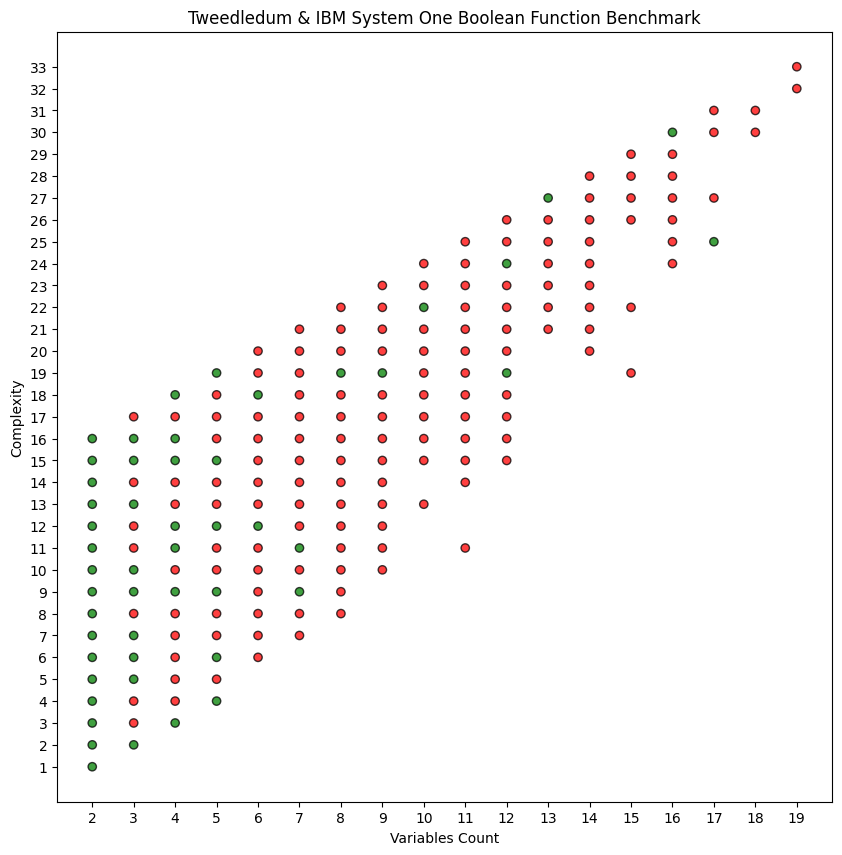

In [34]:

threshold = 0.5
colors = ['green' if p > threshold else 'red' for p in probability_data]


plt.figure(figsize=(10, 10))
plt.scatter(num_vars_data, complexity_data, c=colors, edgecolors='black', alpha=0.75)
plt.xticks(np.arange(min(num_vars_data), max(num_vars_data) + 1, 1))
plt.yticks(np.arange(min(complexity_data), max(complexity_data) + 1, 1))

plt.xlabel('Variables Count')
plt.ylabel('Complexity')
plt.title('Tweedledum & IBM System One Boolean Function Benchmark')
plt.show()